# Setup

In [ ]:
!git clone https://github.com/haochen23/fine-tune-MaskRcnn.git
!cp -r fine-tune-MaskRcnn/beagle/ ./beagle/

# Randomize Test/Eval + Generate json

In [44]:
def rnd_val_train():
    rnd = random.randrange(1,20)
    if rnd == 1:
        return True
    else:
        return False

In [43]:
import cv2
import os
import random
import shutil
import json
file = 'hand/json_hand_segmentation.json'
folder = 'hand/PNGImages1'
train_folder = 'hand/train'
val_folder = 'hand/val'
#Remove old img
for f in os.listdir(train_folder):
    os.remove(os.path.join(train_folder, f))
for f in os.listdir(val_folder):
    os.remove(os.path.join(val_folder, f))
#open old json
with open(file, 'r') as f:
  data2 = json.load(f)
#print(data2)
i = 0
#print(rnd)
json_global_train = {}
json_global_val = {}
for element in data2['samples']:
    #print(element['imageUrl'][45:])
    im = cv2.imread(os.path.join(folder, element['imageUrl'][45:]))
    val = rnd_val_train()
    if val:
        shutil.copyfile(os.path.join(folder, element['imageUrl'][45:]), os.path.join(val_folder, str(i)+".jpg"))
    else:
        shutil.copyfile(os.path.join(folder, element['imageUrl'][45:]), os.path.join(train_folder, str(i)+".jpg"))
    #print(im.shape[0])
    regions = []
    for shape in element['annotation']:
        all_points_x = []
        all_points_y = []
        for points in shape['points']:
            all_points_x.append(int(points['x']*im.shape[0]))
            all_points_y.append(int(points['y']*im.shape[1]))
        #print(element['imageUrl'][45:])
        #print((shape['classification']))
        json_el = {
            'shape_attributes':{
                'name': shape['regionType'],
                'all_points_x' : all_points_x,
                'all_points_y' : all_points_y
            },
            'region_attributes' : {
                'name' : shape['classification']
            }
        }
        regions.append(json_el)
    #print(f"{i:08d}")
    json_al = {
        'filename' : str(i)+".jpg",
        'size' : int(im.shape[0]*im.shape[1]),
        'regions' : regions,
        'file_attributes' : {} 
    }
    json_bl = {
        str(i)+".jpg"+str(int(im.shape[0]*im.shape[1])) : json_al
    }
    if val:
        json_global_val.update(json_bl)
    else:
        json_global_train.update(json_bl)
    i=i+1
        
json_val = json.dumps(json_global_val)
json_train = json.dumps(json_global_train)
with open("hand/val/via_region_data.json", "w") as outfile:
    outfile.write(json_val)
with open("hand/train/via_region_data.json", "w") as outfile:
    outfile.write(json_train)
print("done with dataset")

done with dataset


In [45]:
import os
import numpy as np
import torch
import torch.utils.data
from PIL import Image
import json


class BeagleDataset(torch.utils.data.Dataset):
    def __init__(self, data_dir, transforms=None):
        self.data_dir = data_dir
        self.transforms = transforms
        # load the annotations file, it also contain information of image names
        # load annotations
        annotations1 = json.load(open(os.path.join(data_dir, "via_region_data.json")))
        self.annotations = list(annotations1.values())  # don't need the dict keys
        

    def __getitem__(self, idx):

        # get the image path from the annoations data
        img_name = self.annotations[idx]["filename"]
        img_path = os.path.join(self.data_dir, img_name)
        img = Image.open(img_path).convert("RGB")
        
        # first id is the background, objects count from 1
        obj_ids = np.array(range(len(self.annotations[idx]["regions"]))) +1
        # get bounding box coordinates for each object
        num_objs = len(obj_ids)
        boxes = []
        #print(self.annotations[idx]["filename"])
        for i in range(num_objs):
            xmin = np.min(self.annotations[idx]["regions"][i]["shape_attributes"]["all_points_x"])
            xmax = np.max(self.annotations[idx]["regions"][i]["shape_attributes"]["all_points_x"])
            ymin = np.min(self.annotations[idx]["regions"][i]["shape_attributes"]["all_points_y"])
            ymax = np.max(self.annotations[idx]["regions"][i]["shape_attributes"]["all_points_y"])
            boxes.append([xmin, ymin, xmax, ymax])

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # there is only one class
        labels = torch.ones((num_objs,), dtype=torch.int64)

        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.annotations)

In [46]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
      
def build_model(num_classes):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

    # get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model

In [47]:
from engine import train_one_epoch, evaluate
import utils
import transforms as T

def get_transform(train):
    transforms = []
    # converts the image, a PIL image, into a PyTorch Tensor
    transforms.append(T.ToTensor())
    if train:
        # during training, randomly flip the training images
        # and ground-truth for data augmentation
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

# use our dataset and defined transformations
#dataset = BeagleDataset('beagle/train', get_transform(train=True))
#dataset_test = BeagleDataset('beagle/val', get_transform(train=False))
dataset = BeagleDataset('hand/train', get_transform(train=True))
dataset_test = BeagleDataset('hand/val', get_transform(train=False))
# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=2, shuffle=True, num_workers=10,
    collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=False, num_workers=10,
    collate_fn=utils.collate_fn)

In [48]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)
# our dataset has two classes only - background and beagle
num_classes = 2

# get the model using our helper function
model = build_model(num_classes)
# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

cuda


In [49]:
# number of epochs
num_epochs = 10
evalutaltion = []
for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evalutaltion.append(evaluate(model, data_loader_test, device=device))

Epoch: [0]  [ 0/59]  eta: 0:01:26  lr: 0.000091  loss: 1.1602 (1.1602)  loss_classifier: 0.9709 (0.9709)  loss_box_reg: 0.0363 (0.0363)  loss_objectness: 0.1404 (0.1404)  loss_rpn_box_reg: 0.0126 (0.0126)  time: 1.4643  data: 0.6361  max mem: 4412
Epoch: [0]  [10/59]  eta: 0:00:33  lr: 0.000952  loss: 0.4862 (0.6917)  loss_classifier: 0.3250 (0.4488)  loss_box_reg: 0.0363 (0.0484)  loss_objectness: 0.1404 (0.1703)  loss_rpn_box_reg: 0.0126 (0.0241)  time: 0.6798  data: 0.0646  max mem: 4716
Epoch: [0]  [20/59]  eta: 0:00:24  lr: 0.001814  loss: 0.3076 (0.5018)  loss_classifier: 0.0912 (0.2675)  loss_box_reg: 0.0294 (0.0410)  loss_objectness: 0.1288 (0.1690)  loss_rpn_box_reg: 0.0103 (0.0244)  time: 0.5991  data: 0.0047  max mem: 4716
Epoch: [0]  [30/59]  eta: 0:00:18  lr: 0.002675  loss: 0.2000 (0.4149)  loss_classifier: 0.0703 (0.2089)  loss_box_reg: 0.0410 (0.0419)  loss_objectness: 0.0736 (0.1406)  loss_rpn_box_reg: 0.0109 (0.0237)  time: 0.5978  data: 0.0040  max mem: 4716
Epoch: [

creating index...
index created!
Test:  [0/7]  eta: 0:00:04  model_time: 0.1135 (0.1135)  evaluator_time: 0.0047 (0.0047)  time: 0.6171  data: 0.4976  max mem: 4724
Test:  [6/7]  eta: 0:00:00  model_time: 0.1084 (0.1091)  evaluator_time: 0.0030 (0.0029)  time: 0.1878  data: 0.0743  max mem: 4724
Test: Total time: 0:00:01 (0.2021 s / it)
Averaged stats: model_time: 0.1084 (0.1091)  evaluator_time: 0.0030 (0.0029)
Accumulating evaluation results...
DONE (t=0.01s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.001
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50

Epoch: [5]  [20/59]  eta: 0:00:23  lr: 0.000500  loss: 0.1496 (0.1445)  loss_classifier: 0.0366 (0.0477)  loss_box_reg: 0.0375 (0.0579)  loss_objectness: 0.0204 (0.0216)  loss_rpn_box_reg: 0.0098 (0.0174)  time: 0.5930  data: 0.0064  max mem: 4724
Epoch: [5]  [30/59]  eta: 0:00:18  lr: 0.000500  loss: 0.1294 (0.1440)  loss_classifier: 0.0366 (0.0495)  loss_box_reg: 0.0311 (0.0551)  loss_objectness: 0.0240 (0.0249)  loss_rpn_box_reg: 0.0100 (0.0145)  time: 0.6467  data: 0.0049  max mem: 4724
Epoch: [5]  [40/59]  eta: 0:00:12  lr: 0.000500  loss: 0.1428 (0.1556)  loss_classifier: 0.0471 (0.0528)  loss_box_reg: 0.0427 (0.0571)  loss_objectness: 0.0283 (0.0266)  loss_rpn_box_reg: 0.0105 (0.0192)  time: 0.6712  data: 0.0067  max mem: 4724
Epoch: [5]  [50/59]  eta: 0:00:05  lr: 0.000500  loss: 0.1324 (0.1583)  loss_classifier: 0.0417 (0.0531)  loss_box_reg: 0.0361 (0.0564)  loss_objectness: 0.0218 (0.0292)  loss_rpn_box_reg: 0.0140 (0.0196)  time: 0.6815  data: 0.0062  max mem: 4724
Epoch: [

Epoch: [8]  [ 0/59]  eta: 0:01:18  lr: 0.000050  loss: 0.0659 (0.0659)  loss_classifier: 0.0195 (0.0195)  loss_box_reg: 0.0061 (0.0061)  loss_objectness: 0.0171 (0.0171)  loss_rpn_box_reg: 0.0232 (0.0232)  time: 1.3249  data: 0.6140  max mem: 4724
Epoch: [8]  [10/59]  eta: 0:00:36  lr: 0.000050  loss: 0.1641 (0.1726)  loss_classifier: 0.0528 (0.0583)  loss_box_reg: 0.0501 (0.0596)  loss_objectness: 0.0279 (0.0284)  loss_rpn_box_reg: 0.0133 (0.0263)  time: 0.7348  data: 0.0640  max mem: 4724
Epoch: [8]  [20/59]  eta: 0:00:26  lr: 0.000050  loss: 0.1777 (0.1696)  loss_classifier: 0.0573 (0.0576)  loss_box_reg: 0.0600 (0.0596)  loss_objectness: 0.0217 (0.0254)  loss_rpn_box_reg: 0.0133 (0.0269)  time: 0.6480  data: 0.0062  max mem: 4724
Epoch: [8]  [30/59]  eta: 0:00:19  lr: 0.000050  loss: 0.1651 (0.1686)  loss_classifier: 0.0536 (0.0567)  loss_box_reg: 0.0541 (0.0631)  loss_objectness: 0.0204 (0.0239)  loss_rpn_box_reg: 0.0148 (0.0250)  time: 0.6473  data: 0.0048  max mem: 4724
Epoch: [

In [50]:
# set to evaluation mode
torch.save(model, 'faster-rcnn-hand-10epoch_21032023_4.pt')
model.eval()
CLASS_NAMES = ['__background__', 'hand']
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [8]:
torch.load('faster-rcnn-hand-100epoch.pt')
model.eval()
CLASS_NAMES = ['__background__', 'hand']
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [51]:
%matplotlib inline
from PIL import Image
import matplotlib.pyplot as plt
import torch
import torchvision.transforms as T
import torchvision
import numpy as np

import cv2
import random
import warnings
warnings.filterwarnings('ignore')


def get_prediction(img_path, confidence):
  """
  get_prediction
    parameters:
      - img_path - path of the input image
      - confidence - threshold value for prediction score
    method:
      - Image is obtained from the image path
      - the image is converted to image tensor using PyTorch's Transforms
      - image is passed through the model to get the predictions
      - class, box coordinates are obtained, but only prediction score > threshold
        are chosen.
    
  """
  img = Image.open(img_path)
  transform = T.Compose([T.ToTensor()])
  img = transform(img).to(device)
  pred = model([img])
  pred_class = [CLASS_NAMES[i] for i in list(pred[0]['labels'].cpu().numpy())]
  pred_boxes = [[(i[0], i[1]), (i[2], i[3])] for i in list(pred[0]['boxes'].detach().cpu().numpy())]
  pred_score = list(pred[0]['scores'].detach().cpu().numpy())
  print(np.max(pred_score))
  try:
        pred_t = [pred_score.index(x) for x in pred_score if x>confidence][-1]
  except IndexError:
    pred_t = [pred_score.index(x) for x in pred_score if x>=np.max(pred_score)][-1]

  pred_boxes = pred_boxes[:pred_t+1]
  pred_class = pred_class[:pred_t+1]
  pred_score = pred_score[:pred_t+1]
  return pred_boxes, pred_class, pred_score

def detect_object(img_path, confidence=0.5, rect_th=2, text_size=0.5, text_th=1):
  """
  object_detection_api
    parameters:
      - img_path - path of the input image
      - confidence - threshold value for prediction score
      - rect_th - thickness of bounding box
      - text_size - size of the class label text
      - text_th - thichness of the text
    method:
      - prediction is obtained from get_prediction method
      - for each prediction, bounding box is drawn and text is written 
        with opencv
      - the final image is displayed
  """
  boxes, pred_cls, pred_score = get_prediction(img_path, confidence)
  img = cv2.imread(img_path)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  # print(len(boxes))
  for i in range(len(boxes)):
    cv2.rectangle(img, (int(boxes[i][0][0]),int(boxes[i][0][1])), (int(boxes[i][1][0]),int(boxes[i][1][1])), color=(0, 255, 0), thickness=rect_th)
    cv2.putText(img,pred_cls[i]+": "+str(round(pred_score[i],3)), (int(boxes[i][0][0]),int(boxes[i][0][1])), cv2.FONT_HERSHEY_SIMPLEX, text_size, (0,255,0),thickness=text_th)
  plt.figure(figsize=(6,6))
  plt.imshow(img)
  plt.xticks([])
  plt.yticks([])
  plt.show()

0.24933624


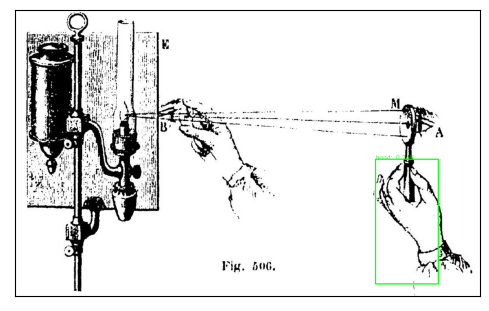

0.077719316


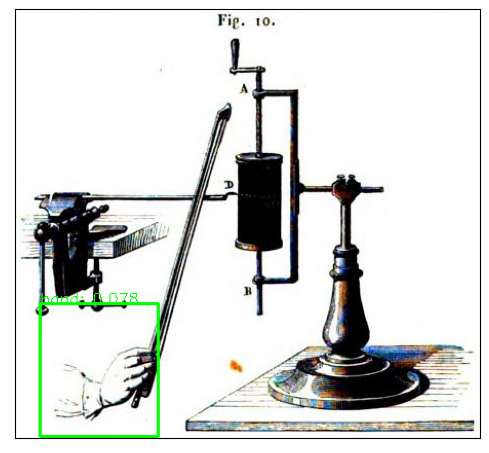

0.30216974


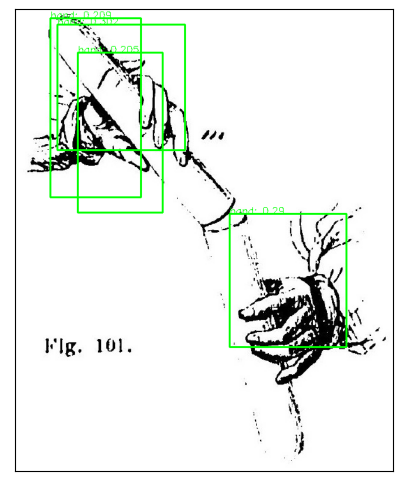

0.527436


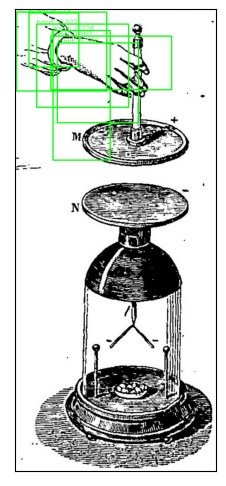

0.42094988


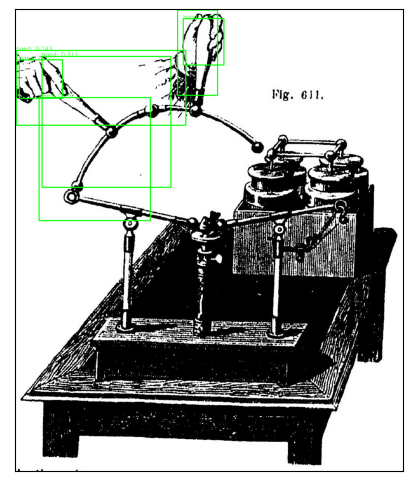

0.382939


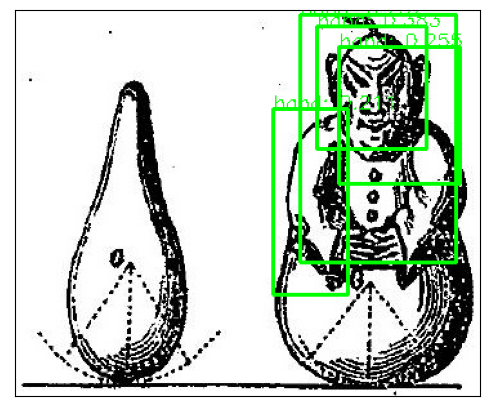

0.38422832


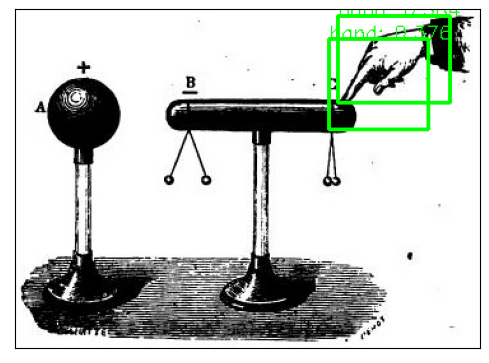

In [58]:
val_dir = 'hand/val' 
for element in os.listdir(val_dir):
    if element[-3:]=='jpg':
        detect_object(os.path.join(val_dir,element),confidence=0.2)
#detect_object('hand/val/6.jpg', confidence=0.3)

based on this : https://haochen23.github.io/2020/06/fine-tune-faster-rcnn-pytorch.html

# Show plots

In [38]:
from io import StringIO
import sys
old_stdout = sys.stdout
output = StringIO()
sys.stdout = output
printed_text = []
for element in evalutaltion:
    element.summarize()
    printed_text.append(output.getvalue())
    output = StringIO()
    sys.stdout = output

# Restore stdout to the console
sys.stdout = old_stdout

# Print the captured text
print(printed_text[0])

IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.026
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.128
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.028
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.022
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.044
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.056
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.062



In [39]:
F1_all = []
AR_all = []
AP_all = []
for element in printed_text:
    i = 0
    AP = []
    AR = []
    F1 = []
    for element_txt in element.splitlines():
        if (i > 0) and (i < 7):
            #print('AP ' + element_txt[74:] + ' ' + str(i))
            AP.append(float(element_txt[74:]))
        if (i > 6) and (i<14):
            #print('AR ' + element_txt[74:]+ ' ' + str(i))
            AR.append(float(element_txt[74:]))
        i=i+1
    for i in range(len(AP)):
        try: 
            F1.append(2*AP[i]*AR[i]/(AP[i]+AR[i]))
        except ZeroDivisionError:
            F1.append('nan')
    print(F1)
    F1_all.append(F1)
    AR_all.append(AR)
    AP_all.append(AP)

[0.023833333333333328, 0.06548837209302326, 0.0, -1.0, 'nan', 0.03857777777777778]
[0.04591304347826086, 0.07715555555555556, 0.0, -1.0, 'nan', 0.05656140350877193]
[0.04636559139784946, 0.07898947368421053, 0.0, -1.0, 'nan', 0.05772413793103449]
[0.04591304347826086, 0.0650887573964497, 0.0, -1.0, 'nan', 0.05656140350877193]


# Plot F1

IoU=0.50:0.95 | area=   all


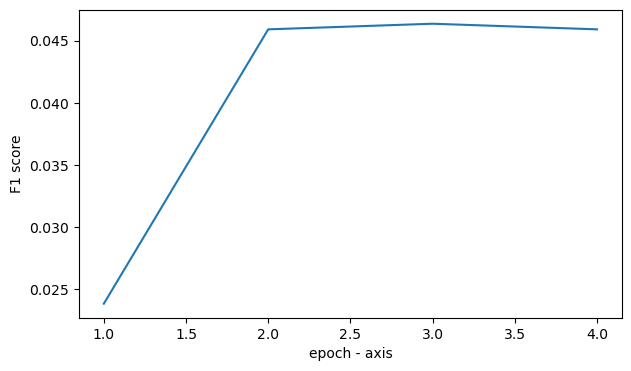

IoU=0.50      | area=   all


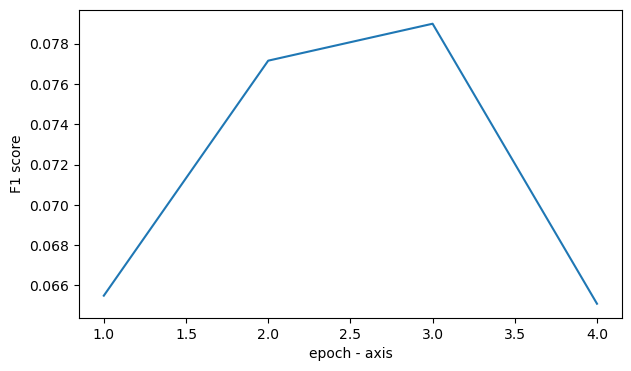

IoU=0.75      | area=   all


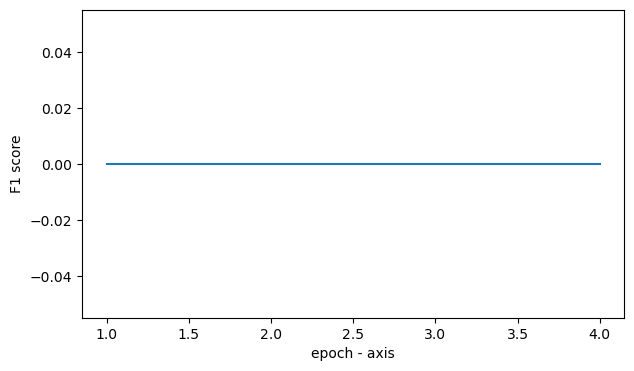

IoU=0.50:0.95 | area= small


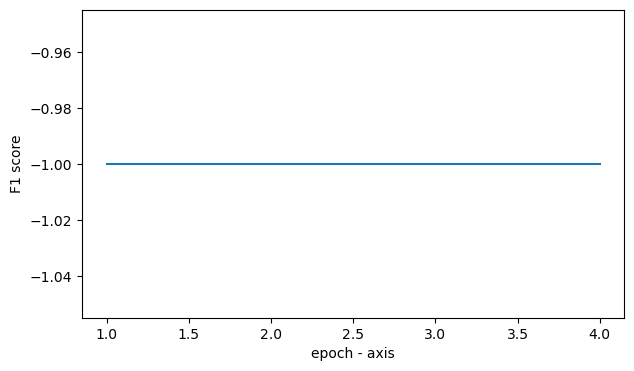

IoU=0.50:0.95 | area=medium


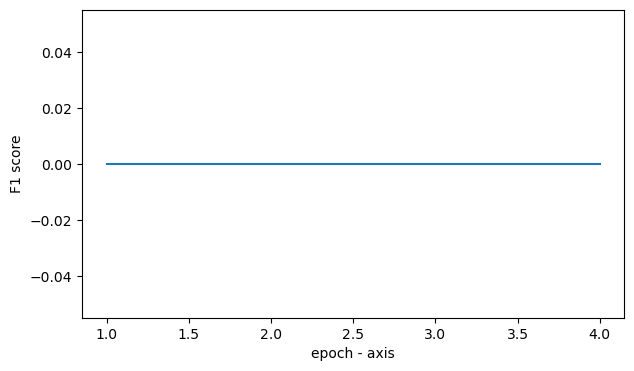

IoU=0.50:0.95 | area= large


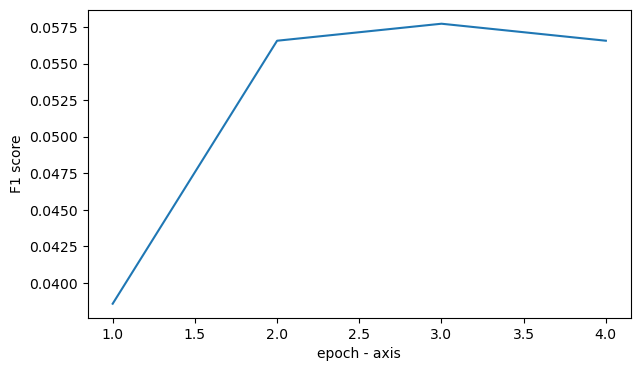

In [40]:
import matplotlib.pyplot as plt
txt = ['IoU=0.50:0.95 | area=   all','IoU=0.50      | area=   all', 'IoU=0.75      | area=   all','IoU=0.50:0.95 | area= small','IoU=0.50:0.95 | area=medium','IoU=0.50:0.95 | area= large']
x = [i for i in range(1, num_epochs+1)]
plt.rcParams['figure.figsize'] = [7, 4]
for i in range(len(F1_all[0])):
        #print(F1_all[0][0])
        y = []
        for j in range(len(F1_all)):
            if F1_all[j][i]=='nan':
                y.append(0)
            else:
                y.append(F1_all[j][i])
        print(txt[i])
        plt.xlabel('epoch - axis')
        plt.ylabel('F1 score')
        plt.plot(x,y)
        plt.show()

# AP-AR Plot

IoU=0.50:0.95 | area=   all


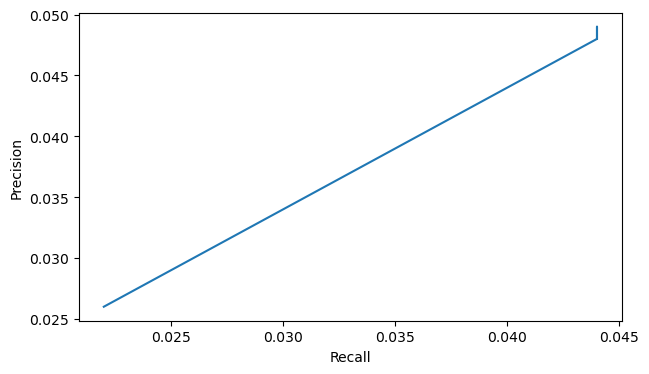

IoU=0.50      | area=   all


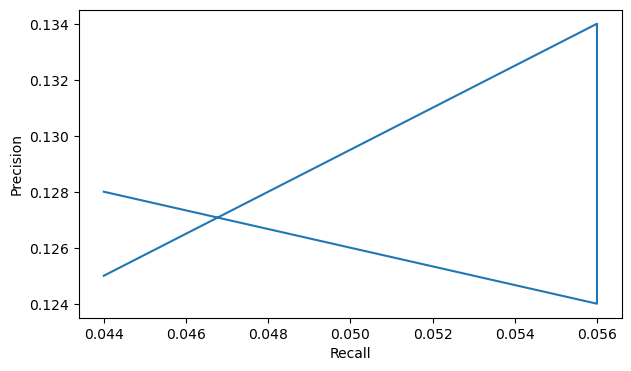

IoU=0.75      | area=   all


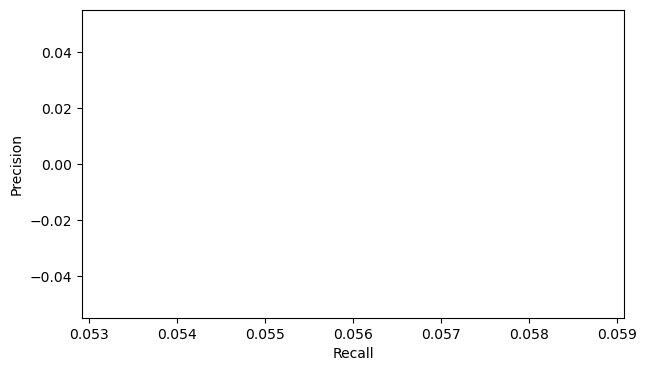

IoU=0.50:0.95 | area= small


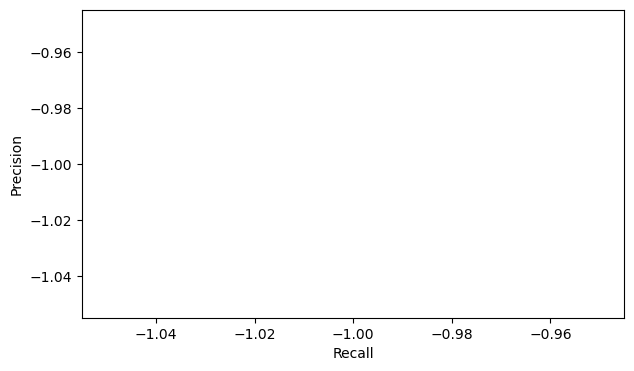

IoU=0.50:0.95 | area=medium


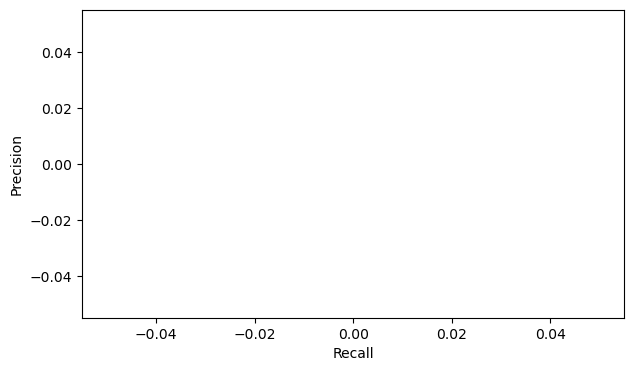

IoU=0.50:0.95 | area= large


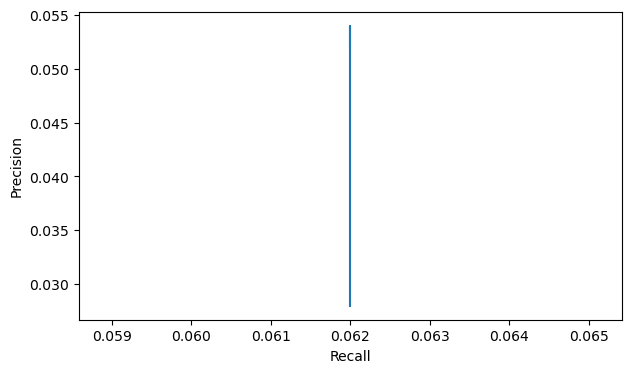

In [41]:
for i in range(len(AR_all[0])):
    x = []
    y = []
    for j in range(len(AR_all)):
        x.append(AR_all[j][i])
        y.append(AP_all[j][i])
    #print(x)
    #print(y)
    print(txt[i])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.plot(x,y)
    plt.show()